# Lab 2 : Decision Tree

## Preparing the dataset

Import necessary libraries and routines.

In [1]:
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import graphviz

Download the data set.

In [2]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


Load dataset from drive to memory in `pandas.DataFrame`.

In [3]:
from ucimlrepo import fetch_ucirepo
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

feature = breast_cancer_wisconsin_diagnostic.data.features
label = breast_cancer_wisconsin_diagnostic.data.targets

Create 4 copies of the original data set. For each one, split it into two parts: train and test. The propotion of splitting for each copy is: 60/40, 40/60, 80/20, 90/10.

In [4]:
X_trains, y_trains = dict(), dict()
X_tests, y_tests = dict(), dict()

train_test_propotions = ['60/40', '40/60', '80/20', '90/10']

for propotion in train_test_propotions:
    test_size = 1 - int(propotion.split('/')[0]) / 100
    X_train, X_test, y_train, y_test = train_test_split(
        feature, label, 
        test_size=test_size,
        stratify=label)
    X_trains[propotion] = X_train
    y_trains[propotion] = y_train
    X_tests[propotion] = X_test
    y_tests[propotion] = y_test

## Building the tree classifier

Train 4 models and save them along with their accuracies.

In [5]:
models = dict()

for propotion in train_test_propotions:
    model = DecisionTreeClassifier()
    model.fit(X_trains[propotion], y_trains[propotion])
    models[propotion] = model

`export_model_image` function exports visualizing image of the decision tree, with a custom name.

In [6]:
def export_model_image(model, filename, save_picture=True):
    dot_data = export_graphviz(model, 
                            out_file=None, 
                            feature_names=[feature_name for feature_name in feature], 
                            class_names=['benign', 'malignant'],
                            filled=True, 
                            rounded=True,
                            special_characters=True)

    graph = graphviz.Source(dot_data)  
    graph.format = 'png'
    graph.render(filename=filename)
    # graph.view()

Export visualizations of all models.

First, create `images` folder to contain all images generated in this notebook. Then create `decision_tree_classifier` inside the `images` folder to contain images for this section.

In [7]:
if os.path.exists('images') == False:
    os.mkdir('images')

In [20]:
if os.path.exists('images/decision_tree_classifier') == False:
    os.mkdir('images/decision_tree_classifier')

for propotion, model in models.items():
    propotion = propotion.replace('/', '-')
    export_model_image(model, f'images/decision_tree_classifier/DT_({propotion})')

## Evaluating the decision tree classifiers

### Explanation

#### `confusion_matrix`

In the confusion matrix $C$, the row represents the actual Benign or Malignant classes, while the column represents the prediction of the model.
- $C_{0,0}$: Both the truth and the prediction are Benign
- $C_{0,1}$: The truth is Benign, but the prediction is Malignant
- $C_{1,0}$: The truth is Malignant, but the prediction is Benign
- $C_{1,1}$: Both the truth and the prediction are Malignant

#### `classification_report`

The Precision, Recall and F1 Score can be calculated based on which type of class is chosen to be Positive. For example: if Malignant as Positive, Benign as Negative. *For more detail, please refer to the report document.*

1. precision: **What percentage of all the Positive predictions made by the model were accurate?** The formula: $$Precision=\frac{True \ Positives}{True \ Positives + False \ Positives}$$

2. recall: **What percentage of all the actual Positives were accurately predicted by the model?** The formula: $$Recall=\frac{True \ Positive}{True \ Positive + False \ Negative}$$

3. F1 Score: **The harmonic mean of Precision and Recall.** If any of them becomes extremely low, F1 Score will also go down. Thus, F1 Score can help you find a good balance between Precision and Recall. The formula: $$F1 \ Score=\frac{2 \times Precision \times Recall}{Precision + Recall}$$

4. Support: **How many samples are in each class.** It uses the ground truth labels, which represent the actual class of each sample.

### Plotting

`plot_evaluation(model_name, cls_report, conf_matrix)` function receives model's name, its classification report and confusion matrix to plot evaluation of the model.

In [9]:
def plot_evaluation(model_name, cls_report, conf_matrix):
    print(f'Model: {model_name}')
    print(f'Classification Report:\n{cls_report}')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['benign', 'malignant'])
    disp.plot()

Create classification report and confusion matrix for each models.

In [10]:
evaluation_metrics = dict()

for model_name, model in models.items():
    cls_report = classification_report(y_tests[model_name], model.predict(X_tests[model_name])) 
    conf_matrix = confusion_matrix(y_tests[model_name], model.predict(X_tests[model_name]))
    evaluation_metrics[model_name] = (cls_report, conf_matrix)

Plotting evaluations of all 4 models

Model: 60/40
Classification Report:
              precision    recall  f1-score   support

           B       0.95      0.97      0.96       143
           M       0.95      0.91      0.93        85

    accuracy                           0.95       228
   macro avg       0.95      0.94      0.94       228
weighted avg       0.95      0.95      0.95       228



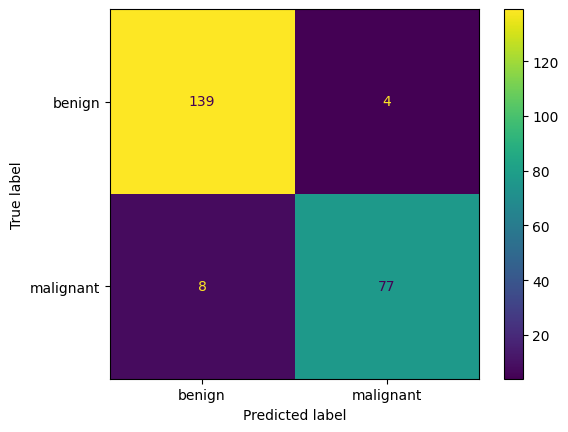

In [11]:
plot_evaluation('60/40', *evaluation_metrics['60/40'])

Model: 40/60
Classification Report:
              precision    recall  f1-score   support

           B       0.91      0.94      0.93       215
           M       0.90      0.85      0.87       127

    accuracy                           0.91       342
   macro avg       0.91      0.90      0.90       342
weighted avg       0.91      0.91      0.91       342



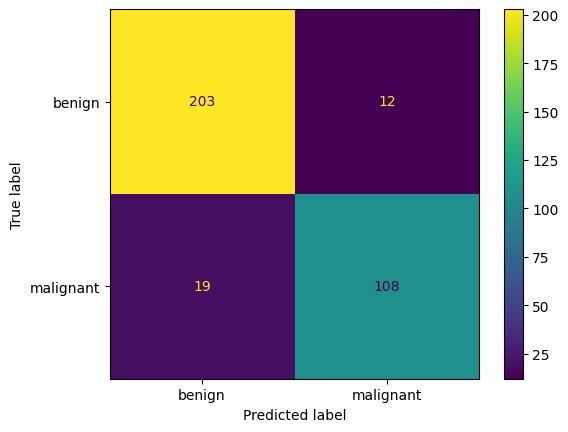

In [12]:
plot_evaluation('40/60', *evaluation_metrics['40/60'])

Model: 80/20
Classification Report:
              precision    recall  f1-score   support

           B       0.97      0.94      0.96        72
           M       0.91      0.95      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



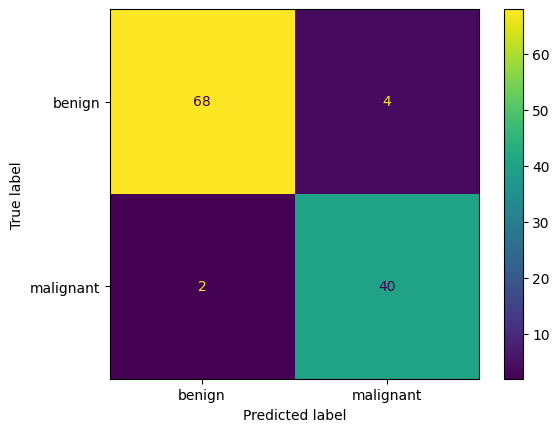

In [13]:
plot_evaluation('80/20', *evaluation_metrics['80/20'])

Model: 90/10
Classification Report:
              precision    recall  f1-score   support

           B       0.92      0.94      0.93        36
           M       0.90      0.86      0.88        21

    accuracy                           0.91        57
   macro avg       0.91      0.90      0.90        57
weighted avg       0.91      0.91      0.91        57



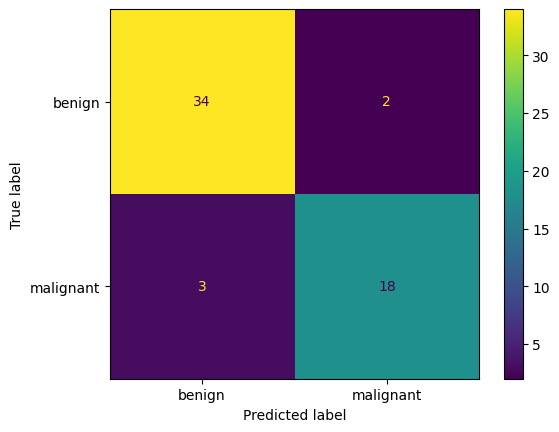

In [14]:
plot_evaluation('90/10', *evaluation_metrics['90/10'])

*For comments, please refer to the report document.*

## The depth and accuracy of a decision tree

This task works on the 80/20 training set and test set.

Prepare the data set.

In [15]:
propotion = '80/20'

X_train, y_train = X_trains[propotion], y_trains[propotion]
X_test, y_test = X_tests[propotion], y_tests[propotion]

Create 7 models with different maximum depths.

In [16]:
max_depths = [None, 2, 3, 4, 5, 6, 7]

models_max_depth = dict()

for max_depth in max_depths:
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    models_max_depth[max_depth] = model

Export all images of this section inside subfolder `model_w_depth_accuracy`. Save accuracy of each model into `accuracies`.

In [24]:
if os.path.exists('images/model_w_depth_accuracy') == False:
    os.mkdir('images/model_w_depth_accuracy')

accuracies = dict()

for max_depth, model in models_max_depth.items():
    export_model_image(model, f'images/model_w_depth_accuracy/DT_max_depth_{max_depth}')
    accuracies[max_depth] = accuracy_score(y_test, model.predict(X_test))

*For comments, please refer to the report document.*